# Chapter 6 - Bayesian Parameter Estimation: Basic Concepts

In [1]:
from __future__ import division
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from ipywidgets import interact

Why?

MLE does **not** give us error bars around the parameter estimate (we get error bars from combining multiple subjects)

In MLE, we focus on $ P(data\mid model) $, or $ P(y\mid \theta) $.

Here, for Bayesian stuff, we want to _reverse_ this direction. The main function of Bayes' theorem _is to make this reversal_.

So we want to get a formula for $ P(\theta \mid y) $.

Bayes theorem, with our variables:

$$ P(\theta \mid y) = \frac{P(y\mid \theta) \times P(\theta)}{P(y)} $$

**Let's put that in words**

$$ \text{probability of $p$ given our data $h$ and $n$} = \frac{\text{prob of our data given $p$} \times \text{prob of $p$}}{\text{prob of our data across all possible parameter $p$ values}} $$

Note that we _want_ the left-hand side (**the posterior**; probability of our model given data we acquire), and we know the stuff on the right--kinda...

Let's break down the things that we need to find in advance, to get our desired **posterior**.

1. $ P(y\mid \theta) $ - **The likelihood**
    > _After we collect our data_, we can get the probability of acquiring that data given our model. <br\>
    > This is the stuff we derived with MLE, so we can do that again.
2. $ P(\theta) $ - **The prior**
    > Our knowledge about the parameters _going into the experiment_. <br\>
    > We can get this before we have any data.
3. $ P(y) $ - **The evidence**
    > _After we collect our data_, we can get the overall probability of the data. <br\>
    > This serves as a normalization factor for the rest, to ensure our results fall between 0 and 1.

---
## Building a model for a coin-toss experiment.

We will walk through the steps of building the prior, likelihood, and evidence, to find the posterior.

## The prior

We often use a **Beta distribution** to represent the prior. Why do we use a beta distribution?

Because with its 2 parameters, it can take many **different shapes**. Moving around the 2 parameters of a normal distribution changes its details, but it generally keeps the same shape (bell curve). Here, the beta can look drastically different across parameter combinations.

### Let's draw the Beta and Bernoulli distributions to get a handle on them.

The Bernoulli distribution takes 2 parameters, $\alpha$ and $\beta$. These _can_ be thought of as, respectively, the probability of "successes" and "failures" in _a series of Bernoulli trials_. **In our case it is helpful to think of them this way.**

In [2]:
x = np.linspace(0,1,1000)

def change_beta_shape(alpha,beta):
    y = stats.beta(alpha,beta).pdf(x)
    plt.plot(x,y)
    plt.title('Beta distribution (pdf)')
    
interact(change_beta_shape,alpha=(.5,5,.5),beta=(.5,5,.5));

interactive(children=(FloatSlider(value=2.5, description=u'alpha', max=5.0, min=0.5, step=0.5), FloatSlider(value=2.5, description=u'beta', max=5.0, min=0.5, step=0.5), Output()), _dom_classes=('widget-interact',))

Again, the Beta distribution can be thought of as _a series of Bernoulli trials_. A **Bernoulli trial** is a coin toss--two possible outcomes. Because there are only 2 possible outcomes, the Bernoulli distribution is a probability _mass_ function (pmf), rather than the probability _density_ functions (pdf) we are more used to.

The Bernoulli distribution takes only 1 parameter, $p$, and it is the probability of a success (eg, heads in a coin toss). So $p$ has to stay between 0 and 1. If the probability of a success is $p$, then the probability of a failure is $1-p$.

As such, the pmf for a Bernoulli trial is a simple equation:

\begin{align}
P(x\mid p) & = p^{x}(1-p)^{1-x} \\
       & = \begin{cases}
        p,   & \text{if } x=1 \\
        1-p, & \text{if } x=0
           \end{cases}
\end{align}

** Consider the result is always $0.5$ if $p=0.5$.

Test this out with the distribution below.

In [3]:
def change_bernoulli_shape(p):
    y = stats.bernoulli(p).pmf(x)
    plt.plot(x,y)
    plt.title('Bernoulli distribution (pmf)')
    
interact(change_bernoulli_shape,p=(0,1,.1));

interactive(children=(FloatSlider(value=0.0, description=u'p', max=1.0), Output()), _dom_classes=('widget-interact',))

**Again, we can get a Beta distribution by sampling a large sequence of Bernoulli trials, and then getting the $\alpha$ and $\beta$ values by counting the _number_ of successes and failures in the sample.**

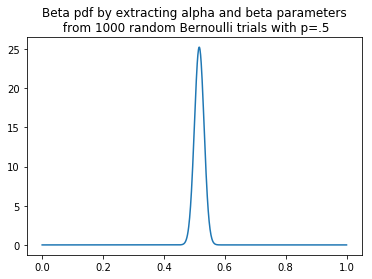

In [4]:
# draw random bernoulli samples
random_bernoullis = stats.bernoulli(.5).rvs(size=1000)

# use those samples to get alpha and beta parameters for beta distribution
alpha = sum(random_bernoullis==1) # total num of successes
beta = sum(random_bernoullis==0) # total num of failures

plt.plot(x, stats.beta(alpha,beta).pdf(x))
plt.title('Beta pdf by extracting alpha and beta parameters\n from 1000 random Bernoulli trials with p=.5');

So the Beta pdf is a series of pulls from a Bernoulli pmf, and represents the number of successes (ie, 1s, represented by $alpha$), and the number of failures (ie, 0s, $beta$).

We can show this another way (reverse of what we did above) by plotting the Beta distribution first, and _then_ use that to get a $p$ for the Bernoulli distribution, and sampling a bunch of Bernoulli trials and plotting the distribution of those.

**Note that the $p$ parameter for the Bernoulli is found from the Beta parameters. Accordingly, the mean of the Beta distribution should center right around $p$. This is important to understand for the following steps.**

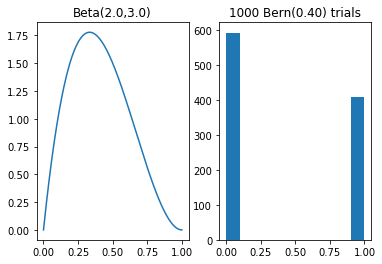

In [5]:
# beta parameters
alpha = 2              # n of total Bernoulli "successes" (ie, 1s)
beta = 3               # n of total Bernoulli "failures" (ie, 0s)

# bernoulli parameter
p = alpha / (alpha+beta)  # probability of success for each Bernoulli trial


f, (ax1,ax2) = plt.subplots(1,2)

ax1.plot(x, stats.beta(alpha,beta).pdf(x));
ax1.set_title('Beta({:.01f},{:.01f})'.format(alpha,beta));

ax2.hist(stats.bernoulli(p).rvs(len(x)));
ax2.set_title('1000 Bern({:.02f}) trials'.format(p));

## The Beta distribution gives us a _confidence range_.

We show this with an example about batting averages.

Replace the coin toss notion with batting average. The Bernoulli distribution always uses the coni toss example, where _we know that the parameter $p = .5$_ because coin tosses are always considered "fair".

But in the batting average case, we can _look for $p$_. Ie, when a batter steps up the plate, what is the probability of that person getting a hit (success), or not (failure).

In this example, we know the batting average of two players ($p=0.33$), but **they went to bat a different amount of times**. This makes it unfair to compare them, so we can use the Beta distribution to construct confidence around each person's average.

We know Johnnie and Jane's batting averages (0.33), but we can input just their at-bats and hits as shape parameters $\alpha$ and $\beta$ into a Beta distribution, and the mean of that distribution will be their batting average. **Importantly, we can look at the area around that mean to see how confident we are about those batting averages (ie, the mean).**

In [6]:
Jane = dict(atbats=24, hits=8)
Johnnie = dict(atbats=6, hits=2)

Because Beta distribution parameters $\alpha$ and $\beta$ can be thought of as number of successes and failures, respectively, from a Bernoulli distribution, we can plot them.

**This is where we get a _probability of that batting average, with a measure of confidence_.** Note that the expectation, or mean, of a beta distribution will give us the $p$ for each person's Bernoulli trial. This is their batting average. This says, in a sense, that every time the person walks up to the plate, they have $p$ chance of getting a hit (Bernoulli success). This is their batting average.

The Beta distribution gives us this value with confidence. Note that the higher the alpha and beta, keeping ratio the same, will thin it out. (try this above!)

area under curve between .15 CIs
0.56415024
area under curve between .15 CIs
0.88980462502
NOTE that the means are overlapping.


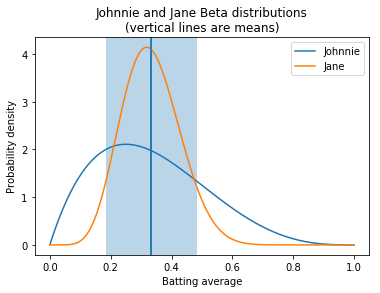

In [7]:
# plot Johnnie's Beta distribution
alpha = Johnnie['hits']                     # a hit is a success
beta = Johnnie['atbats'] - Johnnie['hits']  # nonhit is a failure
plt.plot(x, stats.beta(alpha,beta).pdf(x), label='Johnnie');
# draw a line for the mean
mean = stats.beta(alpha,beta).mean()
plt.axvline(mean)
print 'area under curve between .15 CIs'
print stats.beta(alpha,beta).cdf(.48) - stats.beta(alpha,beta).cdf(.18)

# Jane's
alpha = Jane['hits']
beta = Jane['atbats'] - Jane['hits']
plt.plot(x, stats.beta(alpha,beta).pdf(x), label='Jane');
mean = stats.beta(alpha,beta).mean()
plt.axvline(mean)
print 'area under curve between .15 CIs'
print stats.beta(alpha,beta).cdf(.48) - stats.beta(alpha,beta).cdf(.18)

plt.title('Johnnie and Jane Beta distributions\n(vertical lines are means)');
plt.ylabel('Probability density');
plt.xlabel('Batting average');
plt.legend();

print 'NOTE that the means are overlapping.'

# show the area the book wants to take
# we take the area in this span, under each curve, and see which is higher
plt.axvspan(mean-.15,mean+.15, alpha=.3);

---
## Building a Bayesian model with a coin toss example

We expect our coin to be fair, but let's see how biased our coin really is. Bayesian parameter estimation will give us that confidence (while note that MLE would just give us a single estimate of the coin's fairness).

We will model the coin's fairness (ie, probability of resulting in heads) as the $p$ parameter of a Bernoulli distribution. There are more details on that distribution above.

So we can assume that our coin's fairness is 0.5, so our model is a $\mathrm{Bern}(p=0.5)$ distribution.

<br\>

## 1. Finding the likelihood: $P(y\mid \theta)$

Note that this $P(y\mid \theta)$ notation means the "probability of our data ($y$) given the model, or parameter ($\theta$). When we calculate _likelihoods_, we word $f(\theta \mid y)$ in the reverse order, as the "likelihood of our data given the model". This is confusing, but conveniently, **it means that we are just using that same likelihood function design here**.

Again, the Bernoulli pmf is

$$ P(x\mid p) = p^x (1-p)^{1-x} $$

**The likelihood function represents all the combined probabilities of each data point** (so if there is only one data point, the likelihood function is the same as the pmf). To find a likelihood function, we simply multiply all the probabilities together. ** Note that this number for the likelihood will be very small when we multiply all the probabilities together, and this is why we typically deal with logarithms rather than the raw likelihood, which is often an uninterpretably small value.

So to find the likelihood function, take the product of all $n$ data points

$$ f(\{x_1 \dots x_n\}\mid p) = \prod_{i=1}^{n} p^{x_i} (1-p)^{1-x_i} $$

For convenience, we can just say that $h=$ the number of heads (successes).

$$ f(h,n\mid p) = p^h (1-p)^{n-h} $$

**So that's it**, $f(h,n\mid p)$ is our likelihood function, and we have our first of 3 terms defined to solve for the posterior distribution.

<br\>

**IMPORTANT NOTE:** This equation says that $p$ is fixed and invariant, and so gives us the probability of the outcomes. In MLE, when we _have_ the data and want to _find_ the parameter for the model, it is the same equation, only the data is fixed and invariant, and we are finding the parameter. So it would be the same right-hand side, but notation on the left would flip:

$$ f(p\mid h,n) = p^h (1-p)^{n-h} = L(h,n\mid p) $$

## 2. Finding the prior: $P(\theta)$

We need a probability distribution that describes the likely value of $p$ _before we flip any coins_.

Yes, the whole point of this is to find the true value of $p$ in our resulting posterior distribution. But we have to build a model with a decent amount of error in it to start. What might we expect?

Again, for Bayes stuff, this has to be represented _with a distribution_. The Beta distribution is a sensible model for this case (see above and in the book for reasons why, but in short it is because the 2 parameters of a Beta distribution can be thought of as total number of successes and failures from Bernoulli trials).

The model is that the coin is fair, $\mathrm{Bern}(.5)$. But for our prior, we use a Beta distribution so that there is a level of confidence around that. Ie, the coin might not be _exactly_ fair, maybe there is a microscopic piece of shit attached to one side such that it causes a bias.

We construct a $\mathrm{Beta}(\alpha,\beta)$ and manually add variance to it, to account for possible values for $p$ other than $0.5$ for our coin.

Ahead, we will need to know the equations for the mean, or _expectation_, and variance of a Beta distribution.

If $ X = \mathrm{Beta}(\alpha,\beta)$, then

\begin{align}
E(X) & = \frac{\alpha}{\alpha + \beta} \qquad (E(X)=\text{the mean})\\
\text{and} \\
Var(X) & = \frac{\alpha\beta}{(\alpha+\beta+1)(\alpha+\beta)^2}
\end{align}

First off, we set $\alpha$ and $\beta$ to be the same, since we expect _generally_ equal chance of probability or success.

But we don't know what $\alpha$ and $\beta$ will be. We only know that

\begin{align}
E(X) = 0.5 & = \frac{\alpha}{\alpha + \beta} \\
\text{and therefore} & \\
\alpha & = \beta
\end{align}

But again, $\alpha$ and $\beta$ are unrestricted here.

**We find the $\alpha$ and $\beta$ parameters that will shape our $\mathrm{Beta}(\alpha,\beta)$ by choosing the variance of our $\mathrm{Beta}(\alpha,\beta)$**.


**Now we decide what the variance of our $\mathrm{Beta}(\alpha,\beta)$ will be**, by picked a standard deviation (remember $sd = \sqrt{var}$).

Let's set $SD = 0.1$, so we can use the equation of **variance** (not sd) for a Beta distribution to find the $\alpha$ and $\beta$ values of what will be our prior Beta distribution.

\begin{align}
Var(X) = 0.1^2   & = \frac{\alpha\beta}{(\alpha+\beta+1)(\alpha+\beta)^2} \\
            .01  & = \frac{\alpha\alpha}{(\alpha+\alpha+1)(\alpha+\alpha)^2} \qquad && \text{because }\alpha = \beta \\
                 & = \frac{\alpha^2}{(2\alpha+1)(2\alpha)^2} && \text{join all } \alpha \\
                 & = \frac{\alpha^2}{(2\alpha+1)(4\alpha^2)} && \text{distribute } \alpha \text{ in denominator}\\
                 & = \frac{1}{(2\alpha+1)(4)} && \text{cancel out numerator} \\
                 & = \frac{1}{(8\alpha+1)} && \text{distribute denominator} \\
(8\alpha+1) .01  & = 1 && \text{multiply both sides by denominator} \\
.08\alpha+.01    & = 1 && \text{distribute} \\
.08\alpha        & = .99 \\
\alpha           & = 12
\end{align}

<br\>
**Now we have our $\alpha$ and $\beta$, completing our prior, $P(\theta) = \mathrm{Beta}(\alpha=12,\beta=12)$.** Now in total we have covered 2 of our 3 terms in the Bayes equation.

## 3. Finding the evidence: $P(y)$

The evidence is also known as the _marginal likelihood_. That is, the total, or overall, _possible_ probability obtaining our data; the probability across all possible parameter values. Given that, it should make sense that the purpose of this variable is to "normalize" our results, such that our final probability (the posterior) will be an interpretable value between $0$ and $1$.

I don't really get this part, so let's just take it as they say it.

$$ P(h,n) = \int p^h (1-p)^{n-h} \mathrm{Beta}(p|h,n-h) \mathrm{d}p $$

By "integrating out" $p$, we are taking our data $h$ and $n$ as input, and summing across all possible value of $p$ for that values. This provides us with a marginal probability for our data $h$ and $n$.

We are not really going to concern ourselves with this, and from here on it is only referred to as $P(h,n)$. This is because it involves integration, which is also what makes it confusing. The book appears to apply some magic to it during the next step anyways.

**This is our evidence, the final term needed to apply Bayes theorem and derive the posterior distribution.**

## Executing Bayes theorem

Now we bring it all together by plugging in our terms. Again, we want to find the posterior, $P(\theta|y)$, or now we should write $P(p|h,n)$. This is "the probability of our model, given the data we collected".

As a reminder, the original equation for finding the posterior was: 

$$ P(\theta \mid y) = \frac{P(y\mid \theta) \times P(\theta)}{P(y)} $$

Here is a list of the terms we derived from above:

$ f(h,n\mid p) = p^h (1-p)^{n-h} $

$ P(p) = \mathrm{Beta}(p|\alpha=12,\beta=12) = \frac{p^{\alpha-1}(1-p)^{\beta-1}}{\mathrm{B}(\alpha,\beta)} $

$ P(h,n) = P(h,n) $ <br\>
I know this is stupid just roll with it.

And now we can plug them in do a little simplifying

\begin{align}
P(p\mid y)
& = \frac{p^h (1-p)^{n-h} \times \frac{p^{\alpha-1}(1-p)^{\beta-1}}{\mathrm{B}(\alpha,\beta)}}{P(h,n)} \\
& = \frac{p^{h+(\alpha-1)}(1-p)^{(n-h)+(\beta-1)} \times \frac{1}{\mathrm{B}(\alpha,\beta)}}{P(h,n)} \qquad && \text{combine exponentials} \\
& = \frac{p^{h+(\alpha-1)}(1-p)^{(n-h)+(\beta-1)}}{\mathrm{B}(\alpha,\beta)P(h,n)} && \text{move fraction in numerator to denominator} \\
& = \frac{p^{\alpha+h-1}(1-p)^{\beta+n-h-1}}{\mathrm{B}(\alpha,\beta)P(h,n)} && \text{rearrange the exponentials to prepare us for the key step described below}
\end{align}

**NOW is the trick part.** Now we can recognize that this mess is actually just a Beta distribution with new parameters. This is good, since we want our results to be _in the form of a distribution_; that's what Bayes is all about. Recall the general formula for a Beta distribution.

$$ \mathrm{Beta}(\alpha,\beta \mid p) = \frac{p^{\alpha-1}(1-p)^{\beta-1}}{\mathrm{B}(\alpha,\beta)} $$

and recognize that what we have is this equation, just with a funky $\alpha$ and $\beta$.

Set $\alpha = \alpha+h$, and $\beta = \beta+n-h$.

BTW WE ARE IGNORING ISSUES WITH THE DENOMINATOR AT THIS POINT!!!

We are sort of modding the denominator to fit our needs, which I don't understand yet...

\begin{align}
P(p\mid y)
& = \frac{p^{\alpha+h-1}(1-p)^{\beta+n-h-1}}{\mathrm{B}(\alpha,\beta)P(h,n)} \qquad && \text{rewritten from above} \\
& = \mathrm{Beta}(\alpha+h,\beta+n-h) && \text{rewrite as a Beta distribution}
\end{align}

**Now we're done!**

We decided early on that $\alpha=\beta=12$, so plug them in.

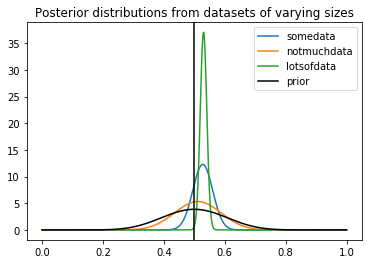

In [8]:
def posterior(h,n):
    alpha = 12+h
    beta = 12+n-h
    return stats.beta(alpha,beta).pdf(x)


# make datasets where the coin is slightly biased towards heads
datasets = {
    'notmuchdata': dict(h=11,n=21),
    'somedata':    dict(h=113,n=213),
    'lotsofdata':  dict(h=1130,n=2130),
}

# get posterior distributions and plot them
for title, ds in datasets.iteritems():
    posterior_distrn = posterior(ds['h'],ds['n'])
    plt.plot(x, posterior_distrn, label=title)
    
# draw line for a "fair" coin
plt.axvline(0.5,c='black')

# plot the prior distribution
plt.plot(x, stats.beta(12,12).pdf(x), c='black', label='prior')

plt.title('Posterior distributions from datasets of varying sizes')
plt.legend();

Though barely visible, note that increased sample size drags our mean away from the prior mean.

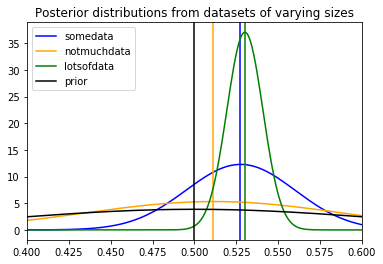

In [9]:
def posterior_incl_mean(h,n):
    alpha = 12+h
    beta = 12+n-h
    distrn = stats.beta(alpha,beta).pdf(x)
    mean = stats.beta(alpha,beta).mean()
    return distrn, mean

colors = ['blue','orange','green']
for i, (title, ds) in enumerate(datasets.iteritems()):
    distrn, mean = posterior_incl_mean(ds['h'],ds['n'])
    plt.plot(x, distrn, c=colors[i], label=title)
    plt.axvline(mean, c=colors[i])
        
plt.plot(x, stats.beta(12,12).pdf(x), c='black', label='prior')
plt.axvline(0.5,c='black')

plt.title('Posterior distributions from datasets of varying sizes')
plt.legend()
        
# zoom in to see the differences
plt.xlim(.4,.6);

This is supposed to emphasize the point that Bayesian stats adhere to the wisdom of Carl Sagan, that extraodinary claims require extraordinary evidence.

That is, to show that our coin is not fair, we need a _lot_ of trials. We can't flip a coin 20 times, get 14 heads, and claim that the coin is unbiased.

### Let's pick one dataset and view the confidence intervals

It's trivial now to get real confidence about our results. We can just take the $95\%$ bounds of our posterior distribution.

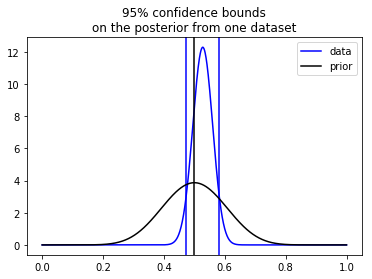

In [10]:
h, n = datasets['somedata'].values()

alpha = 12 + h
beta = 12 + n - h

posterior_distrn = stats.beta(alpha,beta).pdf(x)
low = stats.beta(alpha,beta).ppf(.05)
high = stats.beta(alpha,beta).ppf(.95)

plt.plot(x,posterior_distrn, c='blue', label='data')

plt.axvline(low, c='blue')
plt.axvline(high, c='blue')

plt.plot(x, stats.beta(12,12).pdf(x), c='black', label='prior')
plt.axvline(.5, c='black')

plt.title('95% confidence bounds\non the posterior from one dataset')
plt.legend();

**Now we can do t-tests or whatever.** We can see that a t-test comparing our posterior to $H_0: p=0.5$ would say our results are not significant.

Also, consider that if we expected a biased coin, we could have used a prior distribution of $\mathrm{Beta}(\alpha=13,\beta=12)$ or something (instead of $\alpha=\beta=12$), based on past experiences.

---
## Closing issue

It was easy for us to form a prior distribution to help us solve for the posterior, since we all know how coins act.

But this is often the tough part, picking the prior distribution.

One can use a Uniform distribution, which is 100% uninformative. This can be used if you want to make no predictions about the data beforehand. But there are other ways to estimate priors, and **this is where Monte Carlo simulations come in**. See next chapter.